In [1]:
import os
import numpy as np
from scipy import optimize, interpolate
from os.path import join as pjoin
from matplotlib import pyplot as plt

In [2]:
def r_work_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return 0.091 * np.log(resolution) + 0.134

def delta_r_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return 0.024 * np.log(resolution) + 0.020

def r_free_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return r_work_scaling(resolution) + delta_r_scaling(resolution)

In [3]:
def intersection_two_functions(func1, func2, bracket=[2.3, 4.1]):
    diff_func = lambda x : func1(x) - func2(x)
    intersection = optimize.root_scalar(diff_func, bracket=bracket, method='brentq')
    return intersection.root


def find_where_rfactors_intersect_pdb_dist(r_factor_stack: np.array) -> float:

    # r_factor_table is (resolution, r_work, r_free)
    # linear interpolate this
    resolutions = np.diag(r_factor_stack[:,:,0])
    r_work_cs = interpolate.CubicSpline(resolutions, np.diag(r_factor_stack[:,:,1]))
    r_free_cs = interpolate.CubicSpline(resolutions, np.diag(r_factor_stack[:,:,2]))

    r_work_intersection = intersection_two_functions(r_work_scaling, r_work_cs)
    try:
        r_free_intersection = intersection_two_functions(r_free_scaling, r_free_cs)
    except ValueError:
        r_free_intersection = 0.0
        
    return r_work_intersection, r_free_intersection

In [4]:
def build_rfactor_table_stack(basedir, timepoint, resolutions):
    """ resulting stack is (refinement_res, r_factor_res, res/r_work/r_free) """

    tables = []

    for res in resolutions:

        timepoint_dir = f"{timepoint}-paired-ref-res{res}"
        table_file = f"{timepoint}_refined{res}_rfactor_table.tsv"
        fn_path = pjoin(basedir, timepoint_dir, table_file)

        assert os.path.exists(fn_path), fn_path
        tables.append(np.loadtxt(fn_path))
        
    stack = np.array(tables)

    return stack


def compute_delta_R(rfactor_stack):
    """ returned is an array for the change in R factor over the common set """

    # alternative implementation, harder to understand, but the same
    # r_work_ref_eval_same = np.diag(stack[:,:,1])[:-1]
    # r_work_ref_plus_one = np.diag(stack[1:,:,1])

    delta_rwork = []
    delta_rfree = []

    for i in range(rfactor_stack.shape[0]-1):
        delta_rwork.append(rfactor_stack[i,i,1] - rfactor_stack[i+1,i,1])
        delta_rfree.append(rfactor_stack[i,i,2] - rfactor_stack[i+1,i,2])

    return np.array(delta_rwork), np.array(delta_rfree)

In [21]:
def plot_stack_trace(stack, ax):

    colors = plt.cm.winter(np.linspace(0, 1, stack.shape[0]))

    for i in range(stack.shape[0]):
        substack = stack[i]
        ax.plot(substack[:,0], substack[:,1], 'o-', color=colors[i])
        ax.plot(substack[:,0], substack[:,2], 'o-', color=colors[i], label='_nolegend_')

    ax.set_xlabel("$d_{\mathrm{max}}$ for R factor computation ($\AA$)")
    ax.set_ylabel("R factor over entire resolution range")
    ax.set_xlim([3.75, 2.15])

    ax.legend(RESOLUTIONS, title="refinement $d_{\mathrm{min}}$", ncol=2, fontsize=8)
    
    
def plot_delta_r(stack, ax, legend=False, text=""):

    N = stack.shape[0]
    delta_rwork, delta_rfree = compute_delta_R(stack)

    ax.plot(delta_rwork)
    ax.plot(delta_rfree)

    ax.set_xticks(range(N-1))
    labels = [f"{RESOLUTIONS[i+1]} → {RESOLUTIONS[i]}" for i in range(N-1)]
    ax.set_xticklabels(labels, rotation=30, ha='right')

    ax.set_xlabel("refinement resolution cutoff change ($\AA$)")
    ax.set_ylabel("$\Delta R$ (common reflections)")

    ax.hlines(0.0, -1, N-1, linestyles='--', color='k')
    #ax.set_xlim(-0.5, N-1.5)
    ax.set_xlim(9.5, -0.5)
    ax.set_ylim(-0.005, 0.005)
    
    ax.text(2.5 + 9.5, 0.0045, text, fontsize=20, horizontalalignment='right')
    
    ax.grid()

    if legend:
        ax.legend(['$R_{\mathrm{work}}$', '$R_{\mathrm{free}}$'])
        
        
def plot_resolution_estimator(stack, ax, legend=True):
    
    ax.plot(np.diag(stack[:,:,0]), np.diag(stack[:,:,1]))
    ax.plot(np.diag(stack[:,:,0]), np.diag(stack[:,:,2]))
    ax.plot(RESOLUTIONS, r_work_scaling(RESOLUTIONS), '--', color='k')
    ax.plot(RESOLUTIONS, r_free_scaling(RESOLUTIONS), '--', color='k', label='_nolegend_')
    
    r_work_x, r_free_x = find_where_rfactors_intersect_pdb_dist(stack)
    ax.vlines([r_work_x, r_free_x], 0.15, 0.35, color='grey')

    ax.set_xlabel("resolution cutoff ($\AA$)")
    ax.set_ylabel("R factor")
    ax.set_xlim([3.85, 2.15])
    ax.set_ylim([0.15, 0.4])
    
    ax.grid()

    if legend:
        ax.legend(['$R_{\mathrm{work}}$', '$R_{\mathrm{free}}$', 'PDB mean'], loc=2)
        
    return r_work_x, r_free_x

## plot Rwork and Rfree for each resolution cut, 

In [13]:
#BASEDIR = "/Users/tjlane/Desktop/PL-workshop/paired-refinement"
BASEDIR = "/home/tjlane/scratch/pl-paired-refinement/paired-refinements/"
RESOLUTIONS = [2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
TIMEPOINTS = ['3ps', '300ps', '1ns', '3ns', '10ns', '30ns', '1us', '10us', '30us', '100us']
TIMEPOINT_LABEL = ['3 ps', '300 ps', '1 ns', '3 ns', '10 ns', '30 ns', '1 µs', '10 µs', '30 µs', '100 µs']

In [14]:
stack = build_rfactor_table_stack(BASEDIR, TIMEPOINTS[0], RESOLUTIONS)
print(stack.shape)

(19, 19, 3)


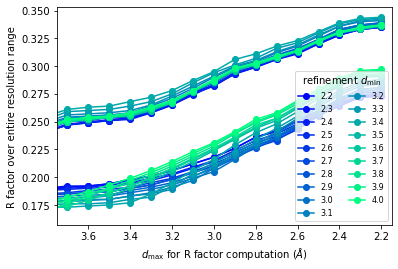

In [15]:
plt.figure()
ax = plt.subplot(111)
plot_stack_trace(stack, ax)
plt.show()

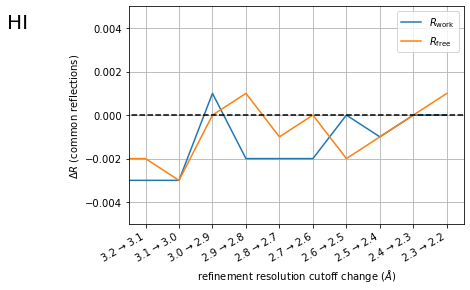

In [18]:
plt.figure()
ax = plt.subplot(111)
plot_delta_r(stack, ax, legend=True, text="HI")
plt.show()

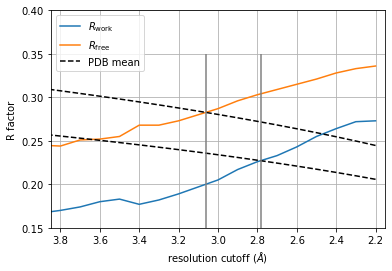

In [10]:
plt.figure()
ax = plt.subplot(111)
plot_resolution_estimator(stack, ax)
plt.show()

## plot all!

3ps	2.78	3.06
300ps	3.09	3.68
1ns	3.02	3.39
3ns	3.03	3.45
10ns	3.31	0.00
30ns	3.27	3.70
1us	3.15	3.71
10us	3.08	3.45
30us	3.22	3.68
100us	3.19	3.59


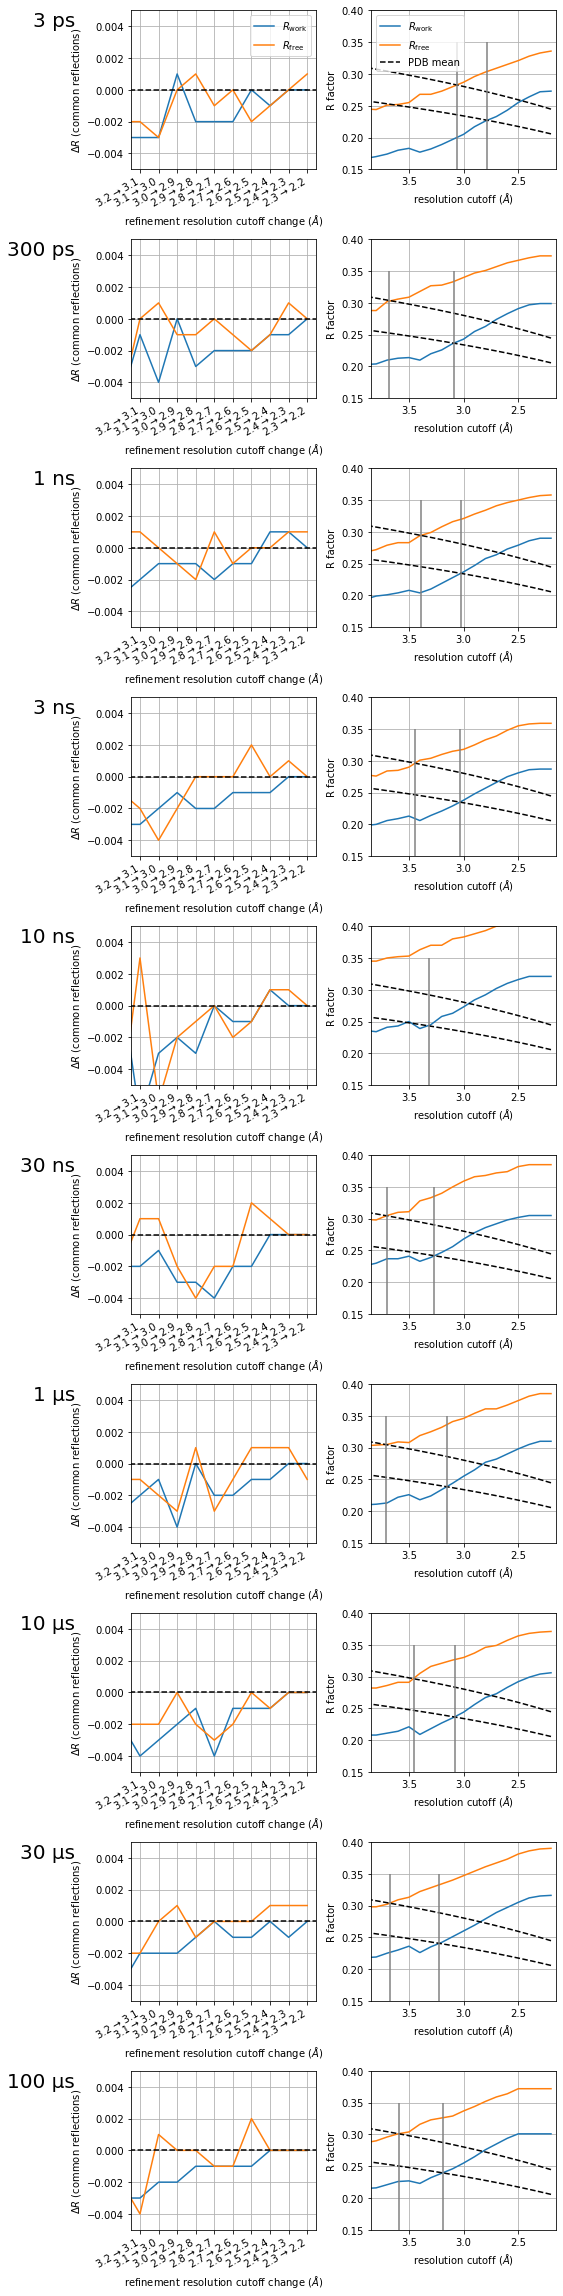

In [19]:
fig, axes = plt.subplots(figsize=(8,32), nrows=len(TIMEPOINTS), ncols=2)

for it,timepoint in enumerate(TIMEPOINTS):
    
    if it == 0:
        legend = True
    else:
        legend = False
    
    stack = build_rfactor_table_stack(BASEDIR, timepoint, RESOLUTIONS)
    
    plot_delta_r(stack, axes[it,0], legend=legend, text=TIMEPOINT_LABEL[it])
    r_work_x, r_free_x = plot_resolution_estimator(stack, axes[it,1], legend=legend)
    
    print(f"{timepoint}\t{r_work_x:.2f}\t{r_free_x:.2f}")

plt.tight_layout()
plt.show()

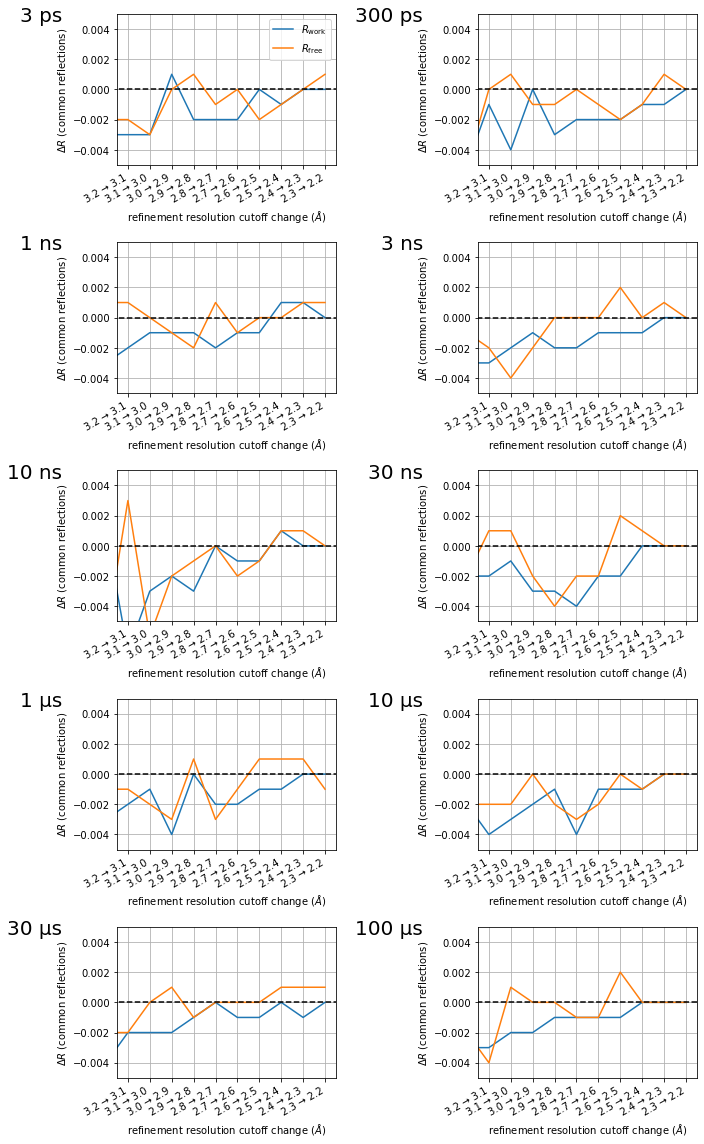

In [22]:
# just the paired refinement plots

nrows = len(TIMEPOINTS) // 2 + len(TIMEPOINTS) % 2
fig, axes = plt.subplots(figsize=(10,16), nrows=nrows, ncols=2)

for it,timepoint in enumerate(TIMEPOINTS):
    
    row = it // 2
    col = it % 2
    
    if it == 0:
        legend = True
    else:
        legend = False
    
    stack = build_rfactor_table_stack(BASEDIR, timepoint, RESOLUTIONS)
    plot_delta_r(stack, axes[row,col], legend=legend, text=TIMEPOINT_LABEL[it])

plt.tight_layout()
plt.savefig('./paired_refinement.pdf')
plt.show()